# Shifting MNIST dataset

In [1]:
import os
import jax
import optax
import dojax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from augly import image
from multiprocessing import Pool

from sklearn.decomposition import PCA

In [2]:
cpu_count = os.cpu_count()
print(f"Number of cores: {cpu_count}")

Number of cores: 96


In [4]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [27]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

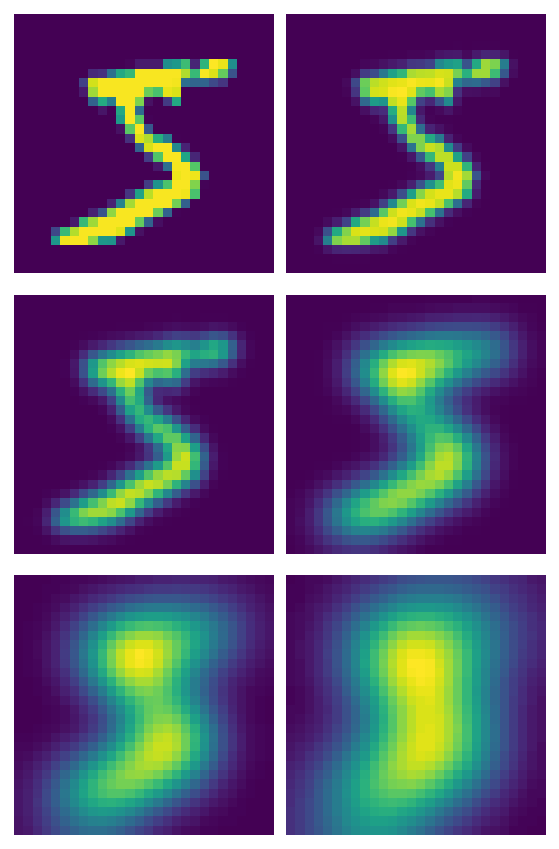

In [5]:
radii = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0]
X_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)

fig, ax = plt.subplots(3, 2, figsize=(4, 6))
for axi, radius in zip(ax.flat, radii):
    x_shift = image.aug_np_wrapper(X_train[0], image.blur, radius=radius)
    axi.imshow(x_shift)
    axi.axis("off")
plt.tight_layout()

In [6]:
class BlurRad:
    def __init__(self, rad):
        self.rad = rad
        
    def __call__(self, img):
        return self.blur_multiple(img)

    def blur(self, X):
        """
        Blur an image using the augly library

        Paramters
        ---------
        X: np.array
            A single NxM-dimensional array
        radius: float
            The amout of blurriness
        """
        return image.aug_np_wrapper(X, image.blur, radius=self.rad)

    def blur_multiple(self, X_batch):
        images_out = []
        for X in X_batch:
            img_blur = self.blur(X)
            images_out.append(img_blur)
        images_out = np.stack(images_out, axis=0)
        return images_out

## Estimating weights

In [13]:
def estimate_weights(model, X, y, key, optimizer, n_epochs=200, seed=None,
                     output_progress=False, print_final_loss=False):
    loss = dojax.make_mse_func(model, X, y)
    batch = jnp.ones((1, 2))
    params = model.init(key, batch)
    opt_state = optimizer.init(params)
    loss_grad_fn = jax.value_and_grad(loss)
    
    for i in range(n_epochs):
        loss_val, grads = loss_grad_fn(params)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        if i % 50 == 0 and output_progress:
            print('Loss step {}: '.format(i), loss_val)
    if print_final_loss:
        print(f"Final loss: {loss_val}")
        
    output = {
        "params": params,
        "final_loss": loss_val,
        "train_accuracy": (model.apply(params, X).round().ravel() == y).mean()
    }
    
    return output

In [14]:
def make_loss_func(model, X, y):
    def loss_fn(params):
        pred = model.apply(params, X)
        loss = optax.softmax_cross_entropy(pred, y).mean()
        return loss
    return loss_fn
    # return jax.jit(loss_fn) # assuming top-levelled funciton is not jitted


class MLPWide(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x):
        # x = x.reshape(-1, 1)
        x = nn.relu(nn.Dense(800)(x))
        x = nn.relu(nn.Dense(500, name="last_layer")(x))
        x = nn.Dense(self.num_outputs)(x)
        x = nn.log_softmax(x)
        return x

    
def print_progress(epoch, loss, step_mod):
    if epoch % step_mod == 0:
        print(f"Loss step ({epoch}: {loss:0.4e})")


@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = make_loss_func(model, X_batch, y_batch)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
    
    return params, opt_step


def proc_dataset(radius, img_dataset, n_processes=90):
    """
    Blur all images of a dataset stored in a numpy array.
    
    Parameters
    ----------
    radius: float
        Intensity of bluriness
    img_dataset: array(N, L, K)
        N images of size LxK
    n_processes: int
        Number of processes to blur over
    """
    pool = Pool(processes=n_processes)
    
    dataset_proc = np.array_split(img_dataset, n_processes)
    dataset_proc = pool.map(BlurRad(radius), dataset_proc)
    dataset_proc = np.concatenate(dataset_proc, axis=0)
    
    pool.close()
    
    return dataset_proc

In [15]:
key = jax.random.PRNGKey(314)

alpha = 0.001
n_classes = 10
n_subset = 5000
batch_size = 2_000
n_epochs = 150
tx = optax.adam(learning_rate=alpha)

model = MLPWide(n_classes)
# X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
# y_train_ohe = jax.nn.one_hot(y_train, n_classes)


def train_model_config(key, radius, num_epochs):
    X_train_proc = proc_dataset(radius, X_train, 90)
    X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
    y_train_ohe = jax.nn.one_hot(y_train, n_classes)

    batch = jnp.ones((1, 28 ** 2))
    params = model.init(key, batch)
    opt_state = tx.init(params)

    for e in range(num_epochs):
        print(f"@epoch {e+1:03}", end="\r")
        _, key = jax.random.split(key)
        params, opt_state = train_epoch(key, params, opt_state, X_train_ravel, y_train_ohe, batch_size, e)

    final_train_acc = (y_train == model.apply(params, X_train_ravel).argmax(axis=1)).mean().item()
    print(f"@{rad=:0.4f}, {final_train_acc=:0.4f}")
    
    return params, final_train_acc

In [19]:
hist_params = []
hist_accuracy = []
radii = jnp.linspace(0.001, 3.00, 100)

time_start = time()
for rad in radii:
    params, train_acc = train_model_config(key, rad, n_epochs)
    
    hist_accuracy.append(train_acc)
    hist_params.append(params)

hist_accuracy = jnp.array(hist_accuracy)
time_end = time()
time_total = time_end - time_start
print(f"Total running time: {time_total:0.2f}s")

@rad=0.0010, final_train_acc=1.0000
@rad=0.0313, final_train_acc=1.0000
@rad=0.0616, final_train_acc=1.0000
@rad=0.0919, final_train_acc=0.9998
@rad=0.1222, final_train_acc=0.9988
@rad=0.1525, final_train_acc=0.9992
@rad=0.1828, final_train_acc=0.9989
@rad=0.2131, final_train_acc=0.9994
@rad=0.2433, final_train_acc=0.9992
@rad=0.2736, final_train_acc=0.9985
@rad=0.3039, final_train_acc=0.9992
@rad=0.3342, final_train_acc=0.9971
@rad=0.3645, final_train_acc=0.9980
@rad=0.3948, final_train_acc=0.9973
@rad=0.4251, final_train_acc=0.9985
@rad=0.4554, final_train_acc=0.9992
@rad=0.4857, final_train_acc=0.9984
@rad=0.5160, final_train_acc=0.9977
@rad=0.5463, final_train_acc=0.9985
@rad=0.5766, final_train_acc=0.9982
@rad=0.6069, final_train_acc=0.9984
@rad=0.6372, final_train_acc=0.9978
@rad=0.6674, final_train_acc=0.9973
@rad=0.6977, final_train_acc=0.9987
@rad=0.7280, final_train_acc=0.9980
@rad=0.7583, final_train_acc=0.9968
@rad=0.7886, final_train_acc=0.9971
@rad=0.8189, final_train_acc

https://symbolize.stripped_domain/r/?trace=55a455cf1ac2,7fe7bb64b3bf,55a455f4811f&map= 
*** SIGTERM received by PID 15075 (TID 15075) on cpu 2 from PID 4250; stack trace: ***
https://symbolize.stripped_domain/r/?trace=55a455d417cb,7fe7bb64b3bf&map= 
*** SIGTERM received by PID 15117 (TID 15117) on cpu 8 from PID 4250; stack trace: ***
PC: @     0x55a455cf1ac2  (unknown)  PyObject_GetAttr
PC: @     0x55a455d417cb  (unknown)  _PyFunction_Vectorcall
    @     0x7fe7aaef77fa        992  (unknown)
    @     0x7fe7aaef77fa        992  (unknown)
    @     0x7fe7bb64b3c0  (unknown)  (unknown)
    @     0x7fe7bb64b3c0  482110736  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=55a455d417cb,7fe7aaef77f9,7fe7bb64b3bf&map=7a511a57244151c993b16b37978e7ed7:7fe79c51f000-7fe7ab261d50 
E0215 12:06:52.131314   15117 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
    @     0x55a455f48120  (unknown)  (unknown)
https://symbolize.stripped_do

@rad=1.6671, final_train_acc=0.9818
@rad=1.6974, final_train_acc=0.9785
@rad=1.7277, final_train_acc=0.9817
@rad=1.7580, final_train_acc=0.9726
@rad=1.7883, final_train_acc=0.9784
@rad=1.8186, final_train_acc=0.9795
@rad=1.8489, final_train_acc=0.9713
@rad=1.8792, final_train_acc=0.9717
@rad=1.9095, final_train_acc=0.9665
@rad=1.9397, final_train_acc=0.9692
@rad=1.9700, final_train_acc=0.9651
@rad=2.0003, final_train_acc=0.9521
@rad=2.0306, final_train_acc=0.9410
@rad=2.0609, final_train_acc=0.9586
@rad=2.0912, final_train_acc=0.9558
@rad=2.1215, final_train_acc=0.9396
@rad=2.1518, final_train_acc=0.9498
@rad=2.1821, final_train_acc=0.9434
@rad=2.2124, final_train_acc=0.9429
@rad=2.2427, final_train_acc=0.9503
@rad=2.2730, final_train_acc=0.9395
@rad=2.3033, final_train_acc=0.9268
@rad=2.3336, final_train_acc=0.9324
@rad=2.3638, final_train_acc=0.9202
@rad=2.3941, final_train_acc=0.9315
@rad=2.4244, final_train_acc=0.9195
@rad=2.4547, final_train_acc=0.9145
@rad=2.4850, final_train_acc

https://symbolize.stripped_domain/r/?trace=55a455d414ea,7fe7bb64b3bf&map= 
*** SIGTERM received by PID 22360 (TID 22360) on cpu 56 from PID 4250; stack trace: ***
PC: @     0x55a455d414ea  (unknown)  _PyFunction_Vectorcall
    @     0x7fe7aaef77fa        992  (unknown)
    @     0x7fe7bb64b3c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=55a455d414ea,7fe7aaef77f9,7fe7bb64b3bf&map=7a511a57244151c993b16b37978e7ed7:7fe79c51f000-7fe7ab261d50 
E0215 12:20:45.124577   22360 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0215 12:20:45.147456   22360 process_state.cc:770] RAW: Raising signal 15 with default behavior


@rad=2.8485, final_train_acc=0.8824
@rad=2.8788, final_train_acc=0.9108
@rad=2.9091, final_train_acc=0.8771
@rad=2.9394, final_train_acc=0.8422
@rad=2.9697, final_train_acc=0.8550
@rad=3.0000, final_train_acc=0.8776
Total running time: 2129.13680338859558105468750s


In [31]:
pca = PCA(n_components=2)
hist_params_flat = dojax.flat_and_concat_params(hist_params)
jnp.save("mnist_shift_params.npy", hist_params_flat)
params_proj = pca.fit_transform(hist_params_flat)

Text(0, 0.5, 'Accuracy')

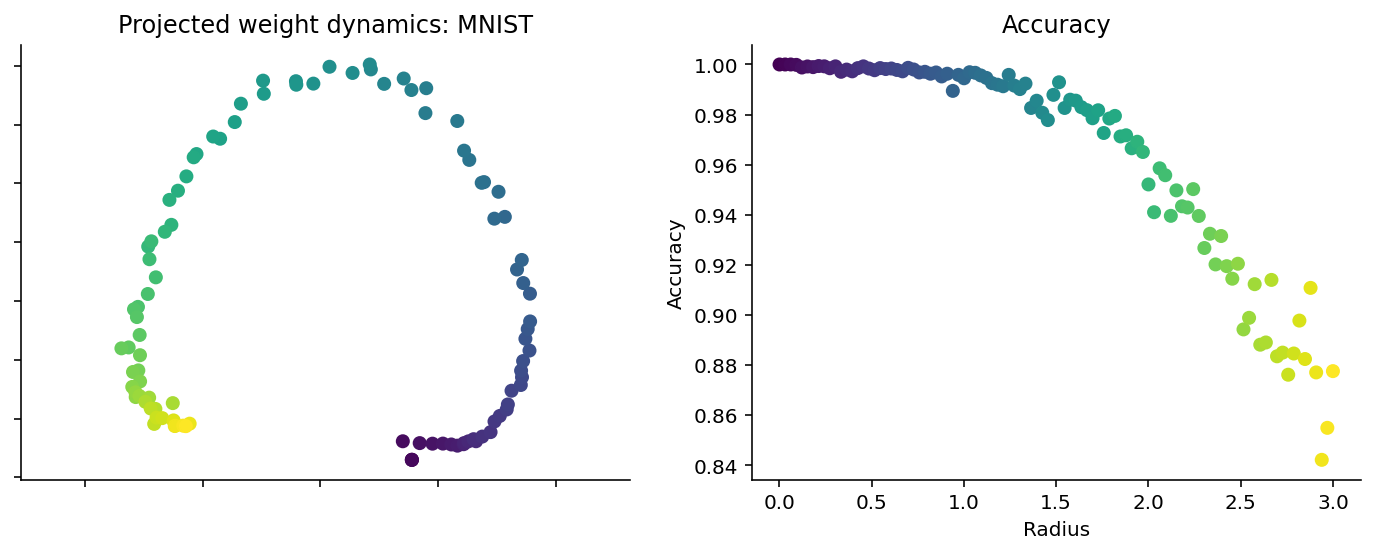

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
ax[0].scatter(*params_proj.T, c=radii)
# ax[0].cb(label="radius")
ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")

ax[1].set_title("Accuracy")
ax[1].scatter(radii, hist_accuracy, c=radii)
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy")